# Intro to Nested Sampling with Gleipnir

In addition to Gleipnir and its dependencies, you will also need matplotlib installed to run this notebook in whole.

## What is Gleipnir?

Gleipnir is a python toolkit that provides an easy to use interface for Nested Sampling that is similar to the calibration tools [PyDREAM](https://github.com/LoLab-VU/PyDREAM) and [SimplePSO](https://github.com/LoLab-VU/ParticleSwarmOptimization). Gleipnir has a built-in implementation of the classic Nested Sampling algorithm, and the toolkit provides a common interface to the Nested Sampling implementations MultiNest, PolyChord, and DNest4. Gleipnir also has some PySB model-specific utilities, including nestedsample_it/NestedSampleIt and HypSelector. 

Through Nested Sampling simulations, Gleipnir can be used to compute the Bayesian evidence (or marginal likelihood) of models. The Bayesian evidence can in turn be used for model selection; i.e., users can select between competing models and determine which one is best supported by the data. And as a side-effect of the evidence calculation, estimates of the posterior distributions of the parameters can also be generated; therefore, Gleipnir can also be used for Bayesian model calibration. 

## Egg Carton likelihood model

In this tutorial, we will cover the basics of setting up and running Nested Sampling simulations of the Egg Carton likelihood landscape using Gleipnir; this example was adapted from the [pymultinest_demo.py](https://github.com/JohannesBuchner/PyMultiNest/blob/master/pymultinest_demo.py). 

For the puroposes of this tutorial, we will use Gleipnir's built-in Nested Sampling implementation; we will cover the interfaces to different Nested Samplers available from Gleipnir in a separate tutorial. 

The Egg Carton likelihood landscape is a common test case for Bayesian sampling schemes. The model is typically two-dimensional (two parameters) and the landscape generated by the likelihood function is a multi-modal egg carton-like shape; see slide 15 of [this pdf](http://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2016/Lecture14_MultiNest.pdf) for a visualization of the likelihood landscape. The parameters are each defined on \[0:10pi\] with uniform priors. 

Here is the Egg Carton loglikelihood function which returns the natural logarithm of the likelihood for a given parameter vector:

In [1]:
# Import NumPy
import numpy as np
# Define the loglikelihood function.
def loglikelihood(parameter_vector):
    chi = (np.cos(parameter_vector)).prod()
    return (2. + chi)**5

### Sampled Parameters

Now that we have our loglikelihood function, let's look at how to define parameters for sampling during the Nested Sampling run. The parameters that are sampled are defined by a list of SampledParameter class instances. The SampledParameter class object stores data on the name of the parameter and the parameter's prior probability distribution. 

In [2]:
# Import the SampledParameters class.
from gleipnir.sampled_parameter import SampledParameter

A new SampledParameter needs two arguments: a name and a object defining the prior.

For priors we can use frozen RV objects from scipy.stats; in special cases you could also write your own prior distribution class objects, but for most purposes scipy.stats distributions will be sufficient.

In [3]:
# Let's import the uniform distribution.
from scipy.stats import uniform

In [4]:
# Now we'll create our list sampled parameters.
# There are two parameters 'x' and 'y',each with a uniform prior on [0:10pi]. 
sampled_parameters = list()
sampled_parameters.append(SampledParameter(name='x', prior=uniform(loc=0.0,scale=10.0*np.pi)))
sampled_parameters.append(SampledParameter(name='y', prior=uniform(loc=0.0,scale=10.0*np.pi)))  

Now we've defined our list of paramters that are to be sampled and their prior probability distributions.  

### The Nested Sampler

Now that we have the loglikelihood function and the sampled parameters setup, let's create our Nested Sampler. First, let's do all our imports.

In [5]:
# Import the Nested Sampler class object.
from gleipnir.nested_sampling import NestedSampling
# Import the sampler we want to use during the Neseted Sampling run.
# In this case, we'll use a Metropololis Monte Carlo sampler adapted for Nested Sampling.
from gleipnir.samplers import MetropolisComponentWiseHardNSRejection
# Import the stopping criterion object. In this case, we'll use a fixed number of iterations.
from gleipnir.stopping_criterion import NumberOfIterations

Now we need to consider the size of our active point population size to use during the Nested Sampling run. For this tutorial, we'll start with 1000. 

In [6]:
# Set the Nested Sampling active point population size.
population_size = 1000

Now, we need to initialize our sampler and stopping criterion objects:

In [7]:
# Initialize the sampler.
sampler = MetropolisComponentWiseHardNSRejection(iterations=20, tuning_cycles=1)
# Initialize the stopping criterion -- We'll stop after 10*population_size Nested Samping iterations.
stopping_criterion = NumberOfIterations(10*population_size)

We've defined our loglikelihood function, our list of sampled parameters, the sampler, and the stopping criterion. We're ready to initialize our Nested Sampling object. 

In [8]:
# Construct the Nested Sampler -- Using the MCMC sampler with hard rejection
# of likelihood levels is an implementation of the classic Nested Sampling algorithm.
NS = NestedSampling(sampled_parameters=sampled_parameters,
                    loglikelihood=loglikelihood, sampler=sampler,
                    population_size=population_size,
                    stopping_criterion=stopping_criterion)

To run the NestedSampling instance we call the run function; the run function has an optional keyword argument 'verbose', which can use to turn on verbose outputs to the standard output during the run. 

In [9]:
# Run Nested Sampling. - The run function returns a tuple with the log_evidence and its error estimate.
log_evidence, log_evidence_error = NS.run(verbose=False)

The natural logarithm of the evidence for the 2-d Egg Carton likelihood model should be approximately 236.

In [10]:
print("log_evidence: {} +- {} ".format(log_evidence, log_evidence_error))

log_evidence: 235.62137927681428 +- 0.07934020316801542 


As we can see, our estimate of the log_evidence is close to the expected value (~236). If you are interested, you can adjust the Nested Sampling hyperparameters (population size, sampler iterations, and Nested Sampling iterations) to see if you refine the estimate even more. Recall that the Egg Carton likelihood landscape is highly multi-modal, so increasing the population size will probably improve the evidence estimates by improving the sampling of the different modes in the landscape.

Besides the log_evidence and its error estimate, we can also get estimates of the evidence and its error, as well as the information.

In [11]:
    # Let's print out the direct evidence estimate. 
    print("evidence: {} +- {}".format(NS.evidence, NS.evidence_error))
    # Let's print out the information and exp(-information). 
    # Note that exp(-information) is an estimate of the fraction of prior space in which the bulk of the
    # posterior mass is located; it is a kind of the compression factor for going from prior to posterior.
    print("Information: {} exp(-Information): {}".format(NS.information, np.exp(-NS.information)))


evidence: 2.1333633916231902e+102 +- 1.0825725540424131
Information: 6.294867838741965 exp(-Information): 0.001845753213975959


#### Posterior marginal distributions

Although the Nested Sampling algorithm was developed primarily as a means of estimating the Bayesian evidence (or marginal likelihood), as a by-product of the Nested Sampling run we can also derive estimates of the posterior marginal distributions of the parameters that were sampled during the simulation. With the Gleipnir Nested Sampling classes we can compute these distributions using the posteriors function:

In [12]:
# Get the posterior distributions -- the posteriors are returned as a dictionary
# keyed to the names of the sampled parameters. Each element is a histogram
# estimate of the marginal distribution, including the heights and centers.
posteriors = NS.posteriors()

In [13]:
# Lets look at the 'x' parameter.
marginal, centers = posteriors['x']

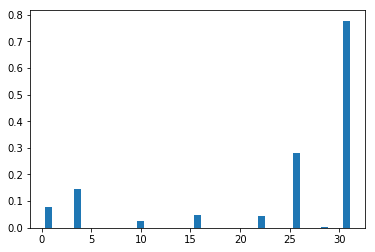

In [14]:
# Now let's plot the distribution using matplotlib.
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(centers, bins=centers, weights=marginal)
plt.show()